In [1]:
import sys
import os

from IPython import display

import numpy as np

# machine learning packages
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from flax.training import train_state, checkpoints
import optax

# our ROMs and FEM stuff
sys.path.append('..')
from fenics import XDMFFile, Mesh, Cell
from fenics import FunctionSpace, Function, Expression
import basix
from basix import ElementFamily, CellType, LagrangeVariant
from surrogates import NonlinearReducedBasisSurrogate as NRBS

2022-03-27 13:37:36.910063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# Configure plotting settings

In [2]:
import matplotlib
import matplotlib.pyplot as plt

fig_dir = "figures/"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True

# Read mesh and reference solution

In [3]:
nu = 0.001
A = 0.5
t_start = 0.0
t_final = 0.5
t_steps = 501
ts = np.linspace(t_start, t_final, t_steps)

file_name = "../output/burgers_1D/nu_" + str(nu) + "/FOM"
xdmffile = XDMFFile(file_name + ".xdmf")

mesh = Mesh()
xdmffile.read(mesh)
V = FunctionSpace(mesh, 'CG', 1)
X = V.tabulate_dof_coordinates()[:, 0]
u = Function(V)
N = V.dim()

u_ref = np.zeros((t_steps, N))
for i in range(t_steps):
    xdmffile.read_checkpoint(u, 'u', i)
    u_ref[i] = u.vector().get_local()

xdmffile.close()


# Plot the reference solution

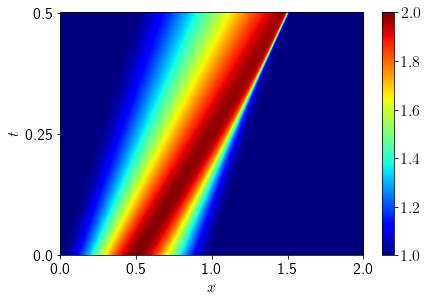

In [4]:
fig, ax = plt.subplots()
im = ax.imshow(u_ref, vmin=1, vmax=2, cmap='jet')
cb_ref = fig.colorbar(im)

ax.set_xlabel("$x$")
ax.set_xlim(N-1,0)
xtick_loc = np.linspace(0, N - 1, 5, dtype=int)
ax.set_xticks(xtick_loc)
ax.set_xticklabels(X[xtick_loc])

ax.set_ylabel("$t$")
ax.set_ylim(0,t_steps)
ax.set_yticks(np.linspace(0, t_steps - 1, 3))
ax.set_yticklabels(np.linspace(t_start, t_final, 3))

ax.set_aspect("auto")

plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_sol_ref.png")
plt.show()
plt.close()


# Define the surrogate model

In [5]:
n = 20
M1 = 100

def surrogate():
    return NRBS(encoder_latents=[M1], N=N, n=n)

## Load the pre-trained surrogate

In [6]:
params = surrogate().init(jax.random.PRNGKey(0), u_ref[0])
tx = optax.adam(0.001)
state = train_state.TrainState.create(apply_fn=surrogate().apply,
                                      params=params,
                                      tx=tx)
CKPT_DIR = "nu_" + str(nu) + "_n_" + str(n)
restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=CKPT_DIR, target=state)
params = params.copy(restored_state.params)


# Compare the reference solution and the approximate solution using the surrogate

## First look at an early step where the solution is smooth

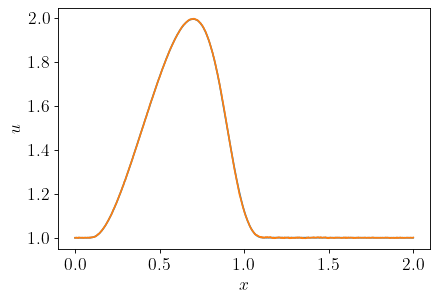

In [7]:
plt.figure(figsize=(6, 4), dpi=80)
u_peek = u_ref[100]
plt.plot(X, u_peek)
plt.plot(X, surrogate().apply(params, u_peek))
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.show()
plt.close()

## Then, look at a late step where the solution is sharp

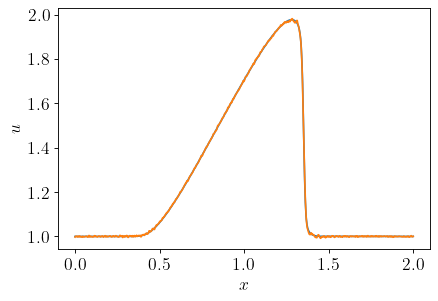

In [8]:
plt.figure(figsize=(6, 4), dpi=80)
u_peek = u_ref[400]
plt.plot(X, u_peek)
plt.plot(X, surrogate().apply(params, u_peek))
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.show()
plt.close()

# Make an animation showing how basis functions are changing as solution becomes sharper

In [9]:
# import matplotlib.animation as animation

# fig = plt.figure(figsize=(6, 8))
# (ax1, ax2) = fig.subplots(2, 1, sharex=True)

# lines1 = ax1.plot([])
# ax1.set_xlim(0, 2)
# ax1.set_ylim(0.5, 2.5)
# ax1.set_ylabel('u')

# lines2 = ax2.plot(np.empty((0, 3)), np.empty((0, 3)))
# ax2.set_xlim(0, 2)
# ax2.set_ylim(-0.3, 0.3)
# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$\phi(u)$')

# Phi_func = jax.jit(jax.jacfwd(lambda params, u: surrogate().apply(params, u, method=NRBS.decode), argnums=1))

# def AnimationFunction(frame):
#     if frame % 100 == 0:
#         print('Writing frame {:}'.format(frame))
#     u_ref_encoded = surrogate().apply(params, u_ref[frame], method=NRBS.encode)
#     Phi = Phi_func(params, u_ref_encoded)
#     lines1[0].set_data((X, u_ref[frame]))
#     lines2[0].set_data((X, Phi.T[0]))
#     lines2[1].set_data((X, Phi.T[1]))
#     lines2[2].set_data((X, Phi.T[2]))

# anim = animation.FuncAnimation(fig, AnimationFunction, frames=t_steps, interval=15)
# writervideo = animation.FFMpegWriter(fps=60)
# anim.save(fig_dir + "nu_" + str(nu) + "_sol_n_" + str(n) + ".mp4", writer=writervideo)

# plt.close()

# Prepare FEM assembly

In [10]:
nelem = mesh.num_cells()

# Per element
nqp = 2
ndof = 2
nvertex = 2
nnode = 2
ndim = 2

# Data structure to be computed per element
dof_map = np.zeros((nelem, ndof), dtype=int)
JxW = np.zeros((nelem, nqp))
grad_test = np.zeros((nelem, nqp, nnode, ndim))

lagrange = basix.create_element(
    ElementFamily.P, CellType.interval, 1, LagrangeVariant.equispaced)
ref_points, weights = basix.make_quadrature(CellType.interval, 2)
test, ref_grad_test = lagrange.tabulate(1, ref_points)
test = test.reshape(2, 2)
ref_grad_test = ref_grad_test.reshape(2, 2)

for e in range(nelem):
    cell = Cell(mesh, e)
    dof_map[e] = V.dofmap().cell_dofs(e)
    coordinates = np.array(cell.get_coordinate_dofs()).reshape(2, 2)
    for qp, weight in enumerate(weights):
        J = jnp.matmul(ref_grad_test[qp], coordinates)
        detJ = jnp.sqrt(jnp.dot(J, J))
        JxW[e][qp] = detJ*weight
        grad_test[e][qp] = jnp.vstack(
            (ref_grad_test[qp]/detJ, jnp.zeros((1, 2)))).T

dof_map = jnp.array(dof_map)
JxW = jnp.array(JxW)
grad_test = jnp.array(grad_test)


# Residual

$r = (w, \dot{u}) + (\nabla w, \nu \nabla u) + (w, u \dot \nabla u)$

In [11]:
def local_residual(dofs, JxW, test, grad_test, ut, ut_old, dt):
    local_re = jnp.zeros((N,))
    for i in range(nnode):
        r = 0
        for qp in range(nqp):
            u = jnp.dot(test[qp], ut[dofs])
            u_old = jnp.dot(test[qp], ut_old[dofs])
            grad_u = jnp.matmul(ut[dofs], grad_test[qp])
            r = r + (test[qp][i]*(u-u_old)/dt+nu*jnp.dot(grad_test[qp]
                     [i], grad_u)+test[qp][i]*grad_u[0]*u) * JxW[qp]
        local_re = local_re.at[dofs[i]].set(r)
    return local_re


# The least-squares objective

In [12]:
def objective(ur, ur_old, dt, params):
    ut = surrogate().apply(params, ur, method=NRBS.decode)
    ut_old = surrogate().apply(params, ur_old, method=NRBS.decode)
    local_res = jax.vmap(local_residual, in_axes=(0,0,None,0,None,None,None), out_axes=0)(dof_map,JxW,test,grad_test,ut,ut_old,dt)
    r = jnp.sum(local_res,axis=0)
    return 0.5*jnp.dot(r,r)

residual = jax.jit(jax.value_and_grad(objective))

jacobian = jax.jit(jax.jacfwd(jax.grad(objective)))

# Newton-Raphson solver

In [13]:
class Divergence(Exception):
    pass

def solve(u, u_old, dt, nl_max_its, RTOL, ATOL):
    def converged(r, r0):
        if jnp.linalg.norm(r) < ATOL:
            return True
        if jnp.linalg.norm(r) < RTOL * jnp.linalg.norm(r0):
            return True
        return False

    obj, r = residual(u, u_old, dt, params)
    r0 = r
    for itr in range(nl_max_its):
        print('Itr = {:}, |R| = {:.3E}, objective = {:.3E}'.format(itr, jnp.linalg.norm(r), obj))

        if converged(r, r0):
            return u
        
        J = jacobian(u, u_old, dt, params)

        du = - jnp.linalg.solve(J, r)
        u = u + du
        obj, r = residual(u, u_old, dt, params)

    raise Divergence

def solve_step(i, t, u, dt, nl_max_its=10, RTOL=1e-6, ATOL=1e-8):
    try:
        i = i + 1
        t = t + dt
        u_old = u
        print('\nstep = {}, t = {}'.format(i, t))
        u = solve(u, u_old, dt, nl_max_its=nl_max_its, RTOL=RTOL, ATOL=ATOL)
    except Divergence:
        display.clear_output(wait=True)
        print('solve failed, cut dt')
        i = i - 1
        t = t - dt
        u = u_old
        i, t, u = solve_step(i, t, u, dt/2, nl_max_its=nl_max_its, RTOL=RTOL, ATOL=ATOL)
        i, t, u = solve_step(i, t, u, dt/2, nl_max_its=nl_max_its, RTOL=RTOL, ATOL=ATOL)
    return i, t, u

# Solve the reduced order model using the surrogate

In [14]:
u0 = Function(V)
u0_expr = Expression(
    "x[0] < 1 ? 1+A*(sin(2*pi*x[0]-pi/2)+1) : 1", degree=1, A=A)
u0.interpolate(u0_expr)

ur0 = surrogate().apply(params, u0.vector().get_local(), method=NRBS.encode)
ur = ur0

i = 0
t = t_start
dt = 0.001
u_approx = [surrogate().apply(params, ur0, method=NRBS.decode)]
while t < t_final:
    i, t, ur = solve_step(i, t, ur, dt, nl_max_its=20, ATOL=1e-9)
    if i % 2 == 0:
        display.clear_output(wait=True)
    u_approx.append(surrogate().apply(params, ur, method=NRBS.decode))
u_approx = np.array(u_approx)


step = 499, t = 0.4990000000000004
Itr = 0, |R| = 2.141E+00, objective = 7.920E-02
Itr = 1, |R| = 5.006E-01, objective = 1.595E-02
Itr = 2, |R| = 7.378E-02, objective = 9.457E-03
Itr = 3, |R| = 2.148E-03, objective = 9.272E-03
Itr = 4, |R| = 1.790E-06, objective = 9.272E-03

step = 500, t = 0.5000000000000003
Itr = 0, |R| = 2.220E+00, objective = 8.033E-02
Itr = 1, |R| = 6.196E-01, objective = 2.092E-02
Itr = 2, |R| = 1.441E-01, objective = 1.034E-02
Itr = 3, |R| = 2.949E-02, objective = 9.453E-03
Itr = 4, |R| = 1.067E-02, objective = 9.372E-03
Itr = 5, |R| = 8.854E-05, objective = 9.365E-03
Itr = 6, |R| = 4.128E-09, objective = 9.365E-03


# Plot the ROM solution

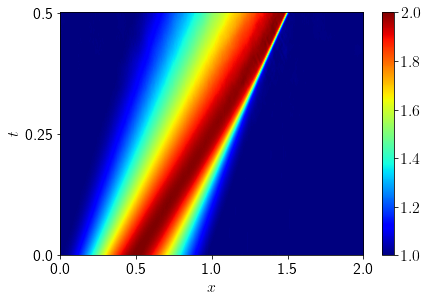

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(u_approx, vmin=1, vmax=2, cmap='jet')
cb_ref = fig.colorbar(im)

ax.set_xlabel("$x$")
ax.set_xlim(N-1, 0)
xtick_loc = np.linspace(0, N - 1, 5, dtype=int)
ax.set_xticks(xtick_loc)
ax.set_xticklabels(X[xtick_loc])

ax.set_ylabel("$t$")
ax.set_ylim(0, t_steps)
ax.set_yticks(np.linspace(0, t_steps - 1, 3))
ax.set_yticklabels(np.linspace(t_start, t_final, 3))

ax.set_aspect("auto")

plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_sol_n_" + str(n)+".png")
plt.show()
plt.close()


# ... and its error (relative to the reference solution)

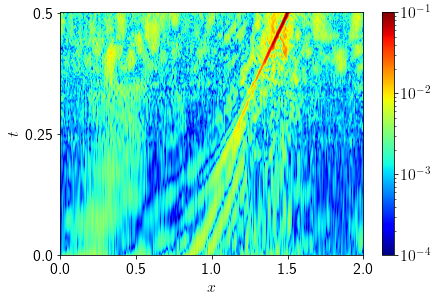

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(np.abs(u_approx - u_ref) / u_ref, cmap='jet', norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e-1))
cb_ref = fig.colorbar(im)

ax.set_xlabel("$x$")
ax.set_xlim(N-1, 0)
xtick_loc = np.linspace(0, N - 1, 5, dtype=int)
ax.set_xticks(xtick_loc)
ax.set_xticklabels(X[xtick_loc])

ax.set_ylabel("$t$")
ax.set_ylim(0, t_steps)
ax.set_yticks(np.linspace(0, t_steps - 1, 3))
ax.set_yticklabels(np.linspace(t_start, t_final, 3))

ax.set_aspect("auto")

plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_err_n_" + str(n)+".png")
plt.show()
plt.close()


In [17]:
data_dir = "data/"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

np.savetxt(data_dir + "nu_" + str(nu) + "_sol_n_" + str(n)+".csv", np.asarray(u_approx))